In [ ]:
#pip install -U scikit-learn

Client program started.
Connected to server at 127.0.0.1:5300
Starting to receive the model structure.
Model structure received. Sending acknowledgment.
Expected length of initial model weights data: 12352 bytes.
Initial model weights received.
Model loaded successfully with received structure and weights.
<Sequential name=sequential, built=True>
Initial size: (172099, 5)
Size after dropping NA: (141197, 5)
Data preprocessing complete.
Compiling and training the model.
Epoch 1/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5647 - loss: 0.7027
Epoch 2/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6526 - loss: 0.6095
Epoch 3/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6973 - loss: 0.5564
Epoch 4/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7118 - loss: 0.5163
Epoch 5/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7426 - loss: 0.4482
Epoch 6/10
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7673 - loss: 0.3935
Epoch 7/10

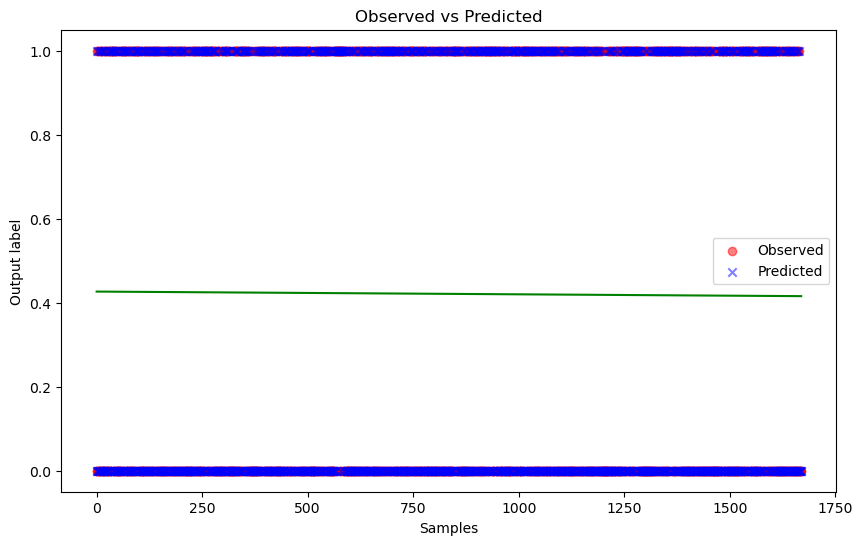

confusion matrix
False Positive Rate: 0.0
False Negative Rate: 0.1548223350253807
True Negative Rate: 1.0
Negative Prediction Value: 0.8784860557768924
False Discovery Rate: 0.0
recall: 0.8451776649746193
precision: 1.0
fbeta: 0.8721843897328445
f1: 0.9160935350756534
f2: 0.8721843897328445
cohen_kappa: 0.8522085300356023
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       882
           1       1.00      0.85      0.92       788

    accuracy                           0.93      1670
   macro avg       0.94      0.92      0.93      1670
weighted avg       0.94      0.93      0.93      1670

ROC_AUC score: 0.9978158776200835
Matthews Correlation Coefficient (MCC): 0.8616709310022458
Updated weights sent.
Receiving the global model from the server
Starting to receive the model structure.
Model structure received. Sending acknowledgment.
Expected length of initial model weights data: 12352 bytes.
Initial model wei

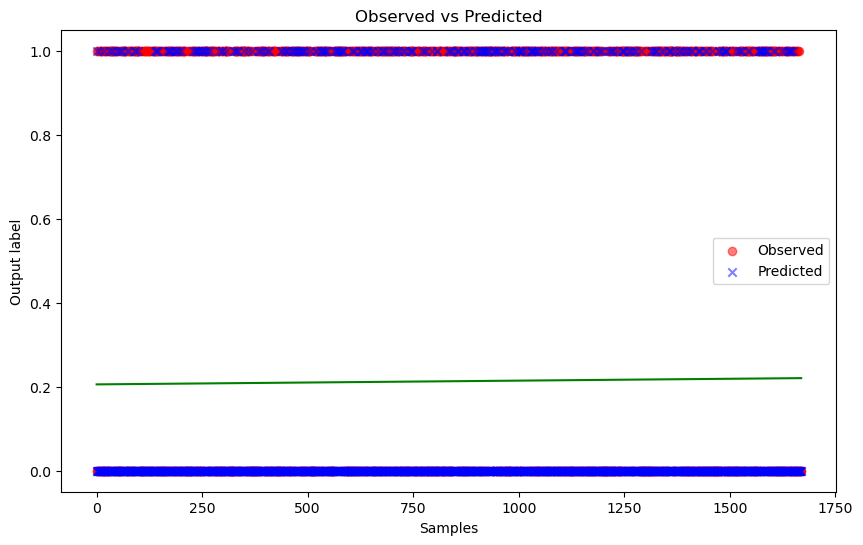

confusion matrix
False Positive Rate: 0.012471655328798186
False Negative Rate: 0.6687817258883249
True Negative Rate: 0.9875283446712018
Negative Prediction Value: 0.623032904148784
False Discovery Rate: 0.04044117647058824
recall: 0.33121827411167515
precision: 0.9595588235294118
fbeta: 0.38113317757009346
f1: 0.4924528301886792
f2: 0.38113317757009346
cohen_kappa: 0.3302711534906465
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76       882
           1       0.96      0.33      0.49       788

    accuracy                           0.68      1670
   macro avg       0.79      0.66      0.63      1670
weighted avg       0.78      0.68      0.64      1670

ROC_AUC score: 0.671916905510089
Matthews Correlation Coefficient (MCC): 0.4309282345452657
Client program completed and connection closed.


In [1]:
# https://neptune.ai/blog/evaluation-metrics-binary-classification
# see the documentation details

import socket
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pickle
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score
import matplotlib.pyplot as plt

def receive_model(client_socket):
    print("Starting to receive the model structure.")
    model_json_parts = []
    
    # Initialize a variable to accumulate the model JSON parts
    while True:
        part = client_socket.recv(1024).decode()
        model_json_parts.append(part)
        # print("Receiving model structure part...")
        if len(part) < 1024:
            # print("End of model structure reached.")
            break  # Exit loop if last part of model structure is received
    
    # Combine the parts to form the full model JSON
    model_json = ''.join(model_json_parts)
    print("Model structure received. Sending acknowledgment.")
    client_socket.send("ACK_MODEL".encode())  # Send acknowledgment for model structure
    
    # Receive the length of the initial model weights data
    length_bytes = client_socket.recv(8)  # Length is expected to be sent as 8 bytes
    length = int.from_bytes(length_bytes, byteorder='big')
    print(f"Expected length of initial model weights data: {length} bytes.")
    
    # Initialize an empty byte string to accumulate the weights data
    initial_weights_data = b""
    while len(initial_weights_data) < length:
        # Calculate the remaining bytes to read
        remaining_bytes = length - len(initial_weights_data)
        packet = client_socket.recv(min(4096, remaining_bytes))
        if not packet:
            raise Exception("Connection closed prematurely while receiving initial model weights.")
        initial_weights_data += packet
    
    # Unpickle the received weights data
    initial_weights = pickle.loads(initial_weights_data)
    print("Initial model weights received.")
    
    # Load the model structure from JSON and set the received weights
    model = tf.keras.models.model_from_json(model_json)
    model.set_weights(initial_weights)
    print("Model loaded successfully with received structure and weights.")
    print(model)
    return model

def preprocess_data_Train_Model(model):
    # Load Maryland crash dataset    
    df = pd.read_csv('Crash_Reporting_Drivers_Data_Maryland_DS.csv')
    # Optionally, check the initial size of the DataFrame
    print("Initial size:", df.shape)

    # Drop rows with missing values more selectively if needed
    df.dropna(inplace=True)

    # Check the size after dropping NA to ensure we still have enough data
    print("Size after dropping NA:", df.shape)

    df = df.iloc[0:8400]

    # Convert 'Crash Date Time' to datetime and extract features
    df['Crash Date Time'] = pd.to_datetime(df['Crash Date Time'])
    df['Hour'] = df['Crash Date Time'].dt.hour
    df['DayOfWeek'] = df['Crash Date Time'].dt.dayofweek
    df['Month'] = df['Crash Date Time'].dt.month

    # Define rush hours (for example, 6-9 AM and 4-7 PM)
    morning_rush = (df['Hour'] >= 6) & (df['Hour'] <= 9)
    evening_rush = (df['Hour'] >= 16) & (df['Hour'] <= 19)
    df['Rush_Hour'] = (morning_rush | evening_rush).astype(int)

    cat = ['Weather', 'Road Condition']
    weather_filter = ['CLEAR','CLOUDY','FOGGY','OTHER','RAINING','SLEET','SNOW','WINTRY MIX']
    road_cond_filter = ['DRY','ICE','OTHER','WET']
    df = df[df['Weather'].isin(weather_filter) & df['Road Condition'].isin(road_cond_filter)]

    encoder = OneHotEncoder(sparse_output=False)
    # One-hot encoding is a common method for 
    # converting categorical variables into a binary matrix representation. 
    # Fit the encoder on the full dataset for the categorical columns
    encoder.fit(df[cat])

    # applies mapping and converts categorical to numerical value
    encoded_features = encoder.transform(df[cat])
    X_numerical = df[['Hour']].values
    
    # Create feature matrix by combining encoded categorical features and numerical 
    X = np.concatenate((encoded_features, X_numerical), axis=1)

    # The target variable 'Rush_Hour' is already binary (0 or 1), so no need to encode
    y = df['Rush_Hour'].values
           
    # combine encoded features, x numarical, y target to df for future need 
    encdfeatnames = encoder.get_feature_names_out(cat)
    df_encd = pd.DataFrame(encoded_features, columns = encdfeatnames)
    df_num = pd.DataFrame(X_numerical, columns = ['Hour'])
    df_rush_hour = pd.DataFrame(y, columns = ['Rush_Hour'])
    
    df_combined = pd.concat([df_encd, df_num, df_rush_hour], axis=1)
    df_combined.to_excel("Laptop1_preprocessedDS.xlsx", index=False, engine='openpyxl')  

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data preprocessing complete.")
    
    print("Compiling and training the model.")
    # for binary classification task
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=12)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Model accuracy: {accuracy}")    
    
    return model, X_test, y_test
def evaluate_model(model, X_test, y_test):
    
    # Evaluating on X_test checks model accuracy on new data;
    # 0.5 is a threshold for binary outcomes
    # Make predictions
    y_pred = model.predict(X_test).ravel() 
    y_pred_binary = (y_pred > 0.5).astype(int)    
    
    print("range(len(y_test)")
    print(range(len(y_test)))
    print("range(len(y_pred)")
    print(range(len(y_pred)))
          
    plt.figure(figsize=(10, 6))

    # Plotting the observed (actual) values vs predicted probabilities
    observed = plt.scatter(range(len(y_test)), y_test, color='red', label='Observed', alpha=0.5, marker='o')

    # Plotting the same for predicted binary outcomes for comparison
    predicted = plt.scatter(range(len(y_pred_binary)), y_pred_binary, color='blue', label='Predicted', alpha=0.5, marker='x')

    # Draw a line of best fit for observed vs predicted
    m, b = np.polyfit(range(len(y_test)), y_pred, 1)
    plt.plot(range(len(y_test)), m*np.arange(len(y_test)) + b, color='green', label='Fit')

    # Enhance plot
    plt.title('Observed vs Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Output label')
    plt.legend(handles=[observed, predicted])
    plt.show()  
    
    # confusion matrix
    # https://neptune.ai/blog/evaluation-metrics-binary-classification
    print("confusion matrix")
    cm = confusion_matrix(y_test, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    false_positive_rate = fp / (fp + tn)
    print(f"False Positive Rate: {false_positive_rate}")
    false_negative_rate = fn / (tp + fn)
    print(f"False Negative Rate: {false_negative_rate}")
    true_negative_rate = tn / (tn + fp)
    print(f"True Negative Rate: {true_negative_rate}")   

    if (tn + fn) > 0:
        negative_predictive_value = tn / (tn + fn)
        print(f"Negative Prediction Value: {negative_predictive_value}")
    else:
        print("Negative Prediction Value: Undefined (no true or false negatives)")
    
    if (tp + fp) == 0:
        false_discovery_rate = 0
        print(f"False Discovery Rate: {false_discovery_rate}")  
    else:
        false_discovery_rate = fp/ (tp + fp)
        print(f"False Discovery Rate: {false_discovery_rate}") 
        
    recall = recall_score(y_test, y_pred_binary) 
    print(f"recall: {recall}")
    precision = precision_score(y_test, y_pred_binary) 
    print(f"precision: {precision}")    
    fbeta = fbeta_score(y_test, y_pred_binary, beta=2)
    print(f"fbeta: {fbeta}")
    f1= f1_score(y_test, y_pred_binary)
    print(f"f1: {f1}")
    f2 = fbeta_score(y_test, y_pred_binary, beta = 2)
    print(f"f2: {f2}")
    cohen_kappa = cohen_kappa_score(y_test, y_pred_binary)
    print(f"cohen_kappa: {cohen_kappa}") 
    
    
    # Classification report (precision, recall, F1-score)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary, zero_division=0))

    # ROC-AUC score
    try:
        roc_auc = roc_auc_score(y_test, y_pred)
        print(f"ROC_AUC score: {roc_auc}")
        
    except:
        # Handle cases where ROC-AUC can not be computed
        print("ROC-AUC score cannot be computed for this model configuration.")
        
    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, y_pred_binary)
    print(f"Matthews Correlation Coefficient (MCC): {mcc}")
    

def send_updated_weights(client_socket, model):
    updated_weights = model.get_weights()
    data = pickle.dumps(updated_weights)
    # Send the size of the pickled data first
    client_socket.sendall(len(data).to_bytes(8, byteorder='big'))
    # Then send the pickled data
    client_socket.sendall(data)
    print("Updated weights sent.")
    
# client_program():
print("Client program started.")
host = '127.0.0.1'   # Server address
port = 5300  # Server port number

client_socket = socket.socket()
client_socket.connect((host, port))
print("Connected to server at {}:{}".format(host, port))

# Receive the initial model from the server
model = receive_model(client_socket)
# Train and preprocess the model
model, X_test, y_test = preprocess_data_Train_Model(model) 
print("Evaluating model after traning with initial model")
evaluate_model(model, X_test, y_test)

# Send the updated weights back to the server
send_updated_weights(client_socket, model)
print('Receiving the global model from the server')    
# Receive the global model from the server
model = receive_model(client_socket)  
print("*****************************************************")
print("Evaluating model after traning with global model")
print("*****************************************************")
# use X_test, y_test from above as server don't send the data set info
evaluate_model(model, X_test, y_test)

client_socket.close()
print("Client program completed and connection closed.")
